In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Window

SparkAppName = 'alpha'

# spark_home = '/opt/cloudera/parcels/SPARK2/lib/spark2'
# os.environ['SPARK_HOME'] = spark_home
# os.environ['PYSPARK_DRIVER_PYTHON'] = 'python'
# os.environ['PYSPARK_PYTHON'] = '/opt/cloudera/parcels/PYENV.GPUAI-3.6.pyenv.p0.2/bin/python'
# os.environ['LD_LIBRARY_PATH'] = '/opt/python/virtualenv/jupyter/lib'
# sys.path.insert(0, os.path.join (spark_home,'python'))
# sys.path.insert(0, os.path.join (spark_home,'python/lib/py4j-0.10.7-src.zip'))

spark = SparkSession.builder\
    .appName(SparkAppName)\
    .master("local[*]")\
    .config('spark.driver.memory', '64g')\
    .config('spark.driver.maxResultSize', '16g')\
    .getOrCreate()

#     .master("yarn-client")\
#     .config('spark.dynamicAllocation.enabled', 'true')\
#     .config('spark.dynamicAllocation.minExecutors',4)\
#     .config('spark.executor.memory','10g')\
#     .config('spark.executor.cores', 7)\
#     .config('spark.yarn.executor.memoryOverhead', '10g')\
#     .config('spark.driver.memory', '6g')\
#     .config('spark.driver.maxResultSize','6g')\
#     .config('spark.kryoserializer.buffer.max', '1g')\
#     .config('spark.excludeOnFailure.enabled', 'true')\
#     .config('spark.excludeOnFailure.timeout', '3h')\
#     .config('spark.excludeOnFailure.task.maxTaskAttemptsPerNode', 2)\
#     .config('spark.sql.broadcastTimeout', 36000)\
#     .config('spark.sql.shuffle.partitions', 2000)\
#     .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
#     .enableHiveSupport()\

22/08/29 17:03:35 WARN Utils: Your hostname, vm2 resolves to a loopback address: 127.0.1.1; using 192.168.0.6 instead (on interface ens192)
22/08/29 17:03:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/29 17:03:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/29 17:03:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
!ls data

data_for_competition.zip  test_target.csv   train_data_2.pq  train_data_7.pq
description.xlsx	  train_data_0.pq   train_data_3.pq  train_data_8.pq
sample_submission.csv	  train_data_10.pq  train_data_4.pq  train_data_9.pq
test_data_0.pq		  train_data_11.pq  train_data_5.pq  train_target.csv
test_data_1.pq		  train_data_1.pq   train_data_6.pq


In [7]:
import ptls
ptls.__file__

'/home/alge/.local/share/virtualenvs/ptls-experiments-vguyIwOn/src/pytorch-lifestream/ptls/__init__.py'

In [8]:
train_target = spark.read.csv("data/train_target.csv", header=True)
train_target.count()

3000000

In [9]:
test_target = spark.read.csv("data/test_target.csv", header=True)
test_target.count()

500000

In [10]:
train_target.show()

+---+----+
| id|flag|
+---+----+
|  0|   0|
|  1|   0|
|  2|   0|
|  3|   0|
|  4|   0|
|  5|   0|
|  6|   0|
|  7|   0|
|  8|   0|
|  9|   0|
| 10|   0|
| 11|   0|
| 12|   0|
| 13|   0|
| 14|   0|
| 15|   0|
| 16|   0|
| 17|   0|
| 18|   0|
| 19|   0|
+---+----+
only showing top 20 rows



In [11]:
train_target.select(F.sum('flag')).collect()[0][0]

106442.0

In [12]:
106442/3000000*100

3.5480666666666667

In [15]:
!ls data

data_for_competition.zip  test_target.csv   train_data_2.pq  train_data_7.pq
description.xlsx	  train_data_0.pq   train_data_3.pq  train_data_8.pq
sample_submission.csv	  train_data_10.pq  train_data_4.pq  train_data_9.pq
test_data_0.pq		  train_data_11.pq  train_data_5.pq  train_target.csv
test_data_1.pq		  train_data_1.pq   train_data_6.pq


In [16]:
train_data = spark.read.parquet("data/train_data")
train_data.count()

26162717

In [18]:
test_data = spark.read.parquet("data/test_data")
test_data.count()

4724601

In [19]:
print(len(train_data.dtypes))
train_data.dtypes

61


[('id', 'bigint'),
 ('rn', 'bigint'),
 ('pre_since_opened', 'bigint'),
 ('pre_since_confirmed', 'bigint'),
 ('pre_pterm', 'bigint'),
 ('pre_fterm', 'bigint'),
 ('pre_till_pclose', 'bigint'),
 ('pre_till_fclose', 'bigint'),
 ('pre_loans_credit_limit', 'bigint'),
 ('pre_loans_next_pay_summ', 'bigint'),
 ('pre_loans_outstanding', 'bigint'),
 ('pre_loans_total_overdue', 'bigint'),
 ('pre_loans_max_overdue_sum', 'bigint'),
 ('pre_loans_credit_cost_rate', 'bigint'),
 ('pre_loans5', 'bigint'),
 ('pre_loans530', 'bigint'),
 ('pre_loans3060', 'bigint'),
 ('pre_loans6090', 'bigint'),
 ('pre_loans90', 'bigint'),
 ('is_zero_loans5', 'bigint'),
 ('is_zero_loans530', 'bigint'),
 ('is_zero_loans3060', 'bigint'),
 ('is_zero_loans6090', 'bigint'),
 ('is_zero_loans90', 'bigint'),
 ('pre_util', 'bigint'),
 ('pre_over2limit', 'bigint'),
 ('pre_maxover2limit', 'bigint'),
 ('is_zero_util', 'bigint'),
 ('is_zero_over2limit', 'bigint'),
 ('is_zero_maxover2limit', 'bigint'),
 ('enc_paym_0', 'bigint'),
 ('enc_p

### Add 1 to all except rn col

In [20]:
for column in train_data.columns:
    if column != 'id' and column != 'rn' and column != 'enc_paym_24' and column != 'enc_paym_20' and column != 'enc_paym_11' and column != 'pre_loans90' and column != 'pre_loans_outstanding':
        train_data = train_data.withColumn(column, F.col(column) + F.lit(1))
        test_data = test_data.withColumn(column, F.col(column) + F.lit(1))

In [21]:
train_data.limit(100).toPandas()

22/08/29 18:04:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,250000,1,9,8,8,3,5,10,6,3,...,4,4,4,4,2,4,5,2,1,1
1,250000,2,15,9,13,11,7,4,13,7,...,4,4,4,4,2,4,5,2,1,1
2,250000,3,11,5,9,12,7,14,6,3,...,4,4,4,4,2,4,5,2,1,1
3,250000,4,14,13,9,7,14,6,13,3,...,4,4,4,4,2,4,5,2,1,1
4,250000,5,7,13,5,15,2,8,5,3,...,4,4,4,4,2,4,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,250014,7,7,3,1,9,15,12,12,3,...,1,1,1,1,2,3,4,2,1,2
96,250014,8,12,18,9,12,16,15,5,3,...,4,4,4,4,2,4,4,2,1,1
97,250014,9,2,10,5,9,2,12,16,6,...,4,4,4,4,2,3,4,2,2,2
98,250014,10,13,11,17,9,13,3,15,3,...,4,4,4,4,2,4,2,2,1,1


### Train

Num clients in train:  3000000

Max num trx:  58
Min num trx:  1
Mean num trx:  8.720905666666667

% of clients with 1 trx:  7.35
% of clients with 2 trx:  7.62
% of clients < 5 trx:  30.19
% of clients < 10 trx:  62.32
% of clients > 30 trx:  0.27


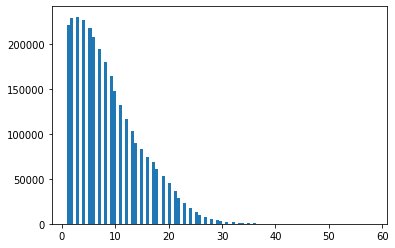

+------+------+
|    id|number|
+------+------+
|250267|     5|
|250622|    15|
|250722|     4|
|250780|    17|
|250953|     4|
|250956|     1|
|251092|    10|
|251310|     4|
|251492|    19|
|251605|     7|
|251719|     1|
|251952|     6|
|252057|    14|
|252993|    13|
|253095|     1|
|253232|    11|
|253472|    14|
|253498|     8|
|253804|    13|
|253815|     9|
+------+------+
only showing top 20 rows



In [14]:
import numpy as np
import matplotlib.pyplot as plt


agg = train_data.groupBy('id').agg(F.count(F.lit(1)).alias("number")).cache()

print()
print('Num clients in train: ', agg.count())
print()
print('Max num trx: ', agg.select(F.max('number').alias('max')).collect()[0]['max'])
print('Min num trx: ', agg.select(F.min('number').alias('min')).collect()[0]['min'])
print('Mean num trx: ', agg.select(F.mean('number').alias('mean')).collect()[0]['mean'])
print()
lens = np.array(agg.select('number').collect())
print('% of clients with 1 trx: ', round(np.sum(lens.squeeze() == 1)/len(lens) * 100, 2))
print('% of clients with 2 trx: ', round(np.sum(lens.squeeze() == 2)/len(lens) * 100, 2))
print('% of clients < 5 trx: ', round(np.sum(lens.squeeze() < 5)/len(lens) * 100, 2))
print('% of clients < 10 trx: ', round(np.sum(lens.squeeze() < 10)/len(lens) * 100, 2))
print('% of clients > 30 trx: ', round(np.sum(lens.squeeze() > 30)/len(lens) * 100, 2))
plt.hist(lens, bins=100)
plt.show()

agg.show()

### Test


Num clients in train:  500000

Max num trx:  57
Min num trx:  1
Mean num trx:  9.449202

% of clients with 1 trx:  6.94
% of clients with 2 trx:  7.07
% of clients < 5 trx:  27.84
% of clients < 10 trx:  57.5
% of clients > 30 trx:  0.37


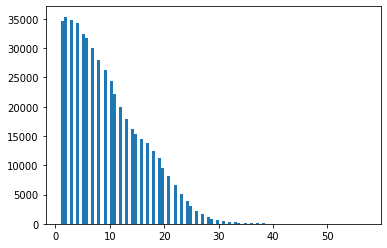

+-------+------+
|     id|number|
+-------+------+
|3250053|    12|
|3250074|     4|
|3250218|     3|
|3250294|    12|
|3250308|     8|
|3250333|    17|
|3250394|     1|
|3251104|     2|
|3251171|    21|
|3251607|    13|
|3251786|     1|
|3251883|    19|
|3252246|     6|
|3252721|     5|
|3252799|    18|
|3253046|     1|
|3253172|    17|
|3253292|     3|
|3253341|    21|
|3253386|    12|
+-------+------+
only showing top 20 rows



In [13]:
agg_test = test_data.groupBy('id').agg(F.count(F.lit(1)).alias("number")).cache()

print()
print('Num clients in train: ', agg_test.count())
print()
print('Max num trx: ', agg_test.select(F.max('number').alias('max')).collect()[0]['max'])
print('Min num trx: ', agg_test.select(F.min('number').alias('min')).collect()[0]['min'])
print('Mean num trx: ', agg_test.select(F.mean('number').alias('mean')).collect()[0]['mean'])
print()
lens_test = np.array(agg_test.select('number').collect())
print('% of clients with 1 trx: ', round(np.sum(lens_test.squeeze() == 1)/len(lens_test) * 100, 2))
print('% of clients with 2 trx: ', round(np.sum(lens_test.squeeze() == 2)/len(lens_test) * 100, 2))
print('% of clients < 5 trx: ', round(np.sum(lens_test.squeeze() < 5)/len(lens_test) * 100, 2))
print('% of clients < 10 trx: ', round(np.sum(lens_test.squeeze() < 10)/len(lens_test) * 100, 2))
print('% of clients > 30 trx: ', round(np.sum(lens_test.squeeze() > 30)/len(lens_test) * 100, 2))
plt.hist(lens_test, bins=100)
plt.show()

agg_test.show()

In [14]:
np.sum(lens.squeeze() < 2)/len(lens)* 100

7.3515

### Number of categories

In [14]:
for col in train_data.columns:
    distinct_in_col_train = train_data.select(F.col(col)).distinct()
    distinct_in_col_test = test_data.select(F.col(col)).distinct()
    print('{0: <30} {1: <10} {2: <10} {3: <10} |     {4: <10} {5: <10} {6}'.format(col, train_data.select(F.col(col)).distinct().count(),
                                                                                  distinct_in_col_train.select(F.min(F.col(col))).toPandas().to_numpy().squeeze().tolist(),
                                                                                  distinct_in_col_train.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist(),
                                                                                  test_data.select(F.col(col)).distinct().count(),
                                                                                  distinct_in_col_test.select(F.min(F.col(col))).toPandas().to_numpy().squeeze().tolist(),
                                                                                  distinct_in_col_test.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist()
                                                                            )
    )

id                             3000000    0          2999999    |     500000     3000000    3499999
rn                             58         1          58         |     57         1          57
pre_since_opened               20         1          20         |     20         1          20
pre_since_confirmed            18         1          18         |     17         1          18
pre_pterm                      18         1          18         |     18         1          18
pre_fterm                      17         1          17         |     17         1          17
pre_till_pclose                17         1          17         |     17         1          17
pre_till_fclose                16         1          16         |     16         1          16
pre_loans_credit_limit         20         1          20         |     20         1          20
pre_loans_next_pay_summ        7          1          7          |     8          1          8
pre_loans_outstanding          5          1   

### Check for missing values

In [40]:
# for c in train_data.columns:
#     print(np.sum(train_data.select([F.count(F.when(F.isnan(c) | F.isnull(c), c))]).toPandas().to_numpy().squeeze()))

### Check for zeros

In [14]:
# for c in train_data.columns:
#     print(np.sum(train_data.filter(train_data[c] == 0).limit(100).toPandas().to_numpy().squeeze()), c)

### Collect lists

In [14]:
# full_train_df = train_data.groupBy('id').agg(*[F.collect_list(col).alias(col) for col in train_data.columns if col != 'id']).join(train_target, ['id']).withColumn('rn', F.reverse('rn'))
# full_train_df = full_train_df.withColumn('flag', full_train_df['flag'].cast('int')).cache()
# valid_df = full_train_df.sample(0.01).cache()
# train_df = full_train_df.join(valid_df, full_train_df.id == valid_df.id, how='left_anti').cache()
# test_df = test_data.groupBy('id').agg(*[F.collect_list(col).alias(col) for col in test_data.columns if col != 'id']).withColumn('rn', F.reverse('rn')).cache()

# print('Full train size:', full_train_df.count())
# print('Valid size:', valid_df.count())
# print('Train size:', train_df.count())
# print('Test size:', test_df.count())

# full_train_df.write.parquet("./full_train.parquet")
# train_df.write.parquet("./train.parquet")
# valid_df.write.parquet("./valid.parquet")
# test_df.write.parquet("./test.parquet")

full_train_df = spark.read.parquet("./full_train.parquet")
train_df = spark.read.parquet("./train.parquet")
valid_df = spark.read.parquet("./valid.parquet")
test_df = spark.read.parquet("./test.parquet")

In [15]:
valid_df.select(F.sum('flag')).collect()[0][0] / 30180 * 100

3.469184890656064

In [16]:
train_df.limit(100).toPandas()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,201,"[4, 3, 2, 1]","[12, 12, 3, 10]","[11, 4, 14, 10]","[5, 10, 14, 5]","[9, 1, 3, 9]","[2, 16, 3, 2]","[12, 15, 7, 12]","[5, 7, 6, 18]","[3, 3, 3, 5]",...,"[4, 4, 4, 4]","[4, 4, 4, 4]","[4, 4, 4, 4]","[5, 2, 2, 2]","[2, 4, 4, 3]","[2, 5, 5, 4]","[2, 2, 2, 2]","[2, 1, 1, 2]","[2, 1, 1, 2]",0
1,232,"[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]","[9, 9, 9, 9, 16, 15, 1, 14, 14, 2, 2]","[8, 7, 5, 13, 4, 9, 9, 7, 7, 4, 4]","[14, 16, 2, 3, 9, 12, 2, 4, 5, 5, 5]","[1, 10, 15, 15, 7, 14, 17, 6, 11, 9, 9]","[5, 5, 10, 10, 10, 6, 6, 14, 2, 2, 2]","[10, 10, 2, 2, 2, 11, 11, 4, 11, 12, 12]","[6, 13, 12, 15, 14, 1, 12, 6, 14, 20, 8]","[3, 2, 3, 3, 3, 3, 3, 2, 7, 3, 3]",...,"[4, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4]","[4, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4]","[4, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4]","[5, 5, 5, 4, 2, 5, 5, 5, 4, 4, 4]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]",0
2,402,"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]","[1, 14, 14, 7, 5, 5, 5, 5, 6, 4, 12, 10, 10]","[2, 15, 9, 7, 18, 18, 7, 6, 17, 1, 1, 17, 3]","[3, 2, 2, 5, 15, 5, 5, 3, 7, 15, 12, 18, 10]","[15, 17, 11, 15, 8, 11, 16, 15, 9, 9, 14, 9, 1]","[4, 17, 17, 2, 9, 2, 2, 12, 1, 15, 15, 9, 2]","[6, 13, 11, 13, 9, 1, 13, 1, 12, 12, 9, 12, 12]","[2, 17, 15, 9, 9, 9, 12, 15, 3, 8, 8, 11, 12]","[3, 3, 3, 4, 3, 3, 1, 3, 6, 3, 6, 7, 6]",...,"[4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4]","[4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4]","[4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3]","[4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 2, 5]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1]",0
3,990,"[6, 5, 4, 3, 2, 1]","[14, 19, 4, 12, 18, 8]","[18, 15, 3, 4, 10, 10]","[5, 9, 18, 12, 17, 5]","[9, 6, 9, 3, 3, 9]","[2, 4, 13, 9, 16, 2]","[12, 6, 12, 15, 1, 12]","[9, 18, 18, 1, 12, 8]","[3, 3, 3, 3, 1, 1]",...,"[4, 4, 4, 4, 4, 4]","[4, 4, 4, 4, 4, 4]","[4, 4, 4, 4, 4, 4]","[2, 2, 2, 2, 2, 2]","[4, 4, 3, 4, 4, 3]","[4, 2, 4, 5, 5, 4]","[2, 2, 2, 2, 2, 2]","[2, 1, 1, 1, 1, 2]","[2, 1, 2, 1, 1, 2]",0
4,1141,"[5, 4, 3, 2, 1]","[9, 1, 1, 1, 7]","[8, 10, 10, 15, 7]","[14, 3, 5, 13, 7]","[1, 11, 15, 16, 2]","[5, 4, 2, 4, 1]","[10, 6, 11, 6, 5]","[13, 20, 11, 4, 15]","[3, 7, 5, 3, 2]",...,"[4, 1, 4, 4, 4]","[4, 1, 4, 4, 4]","[4, 4, 4, 4, 4]","[2, 2, 2, 2, 2]","[4, 4, 4, 4, 3]","[5, 5, 4, 5, 4]","[2, 2, 2, 2, 2]","[1, 1, 2, 1, 1]","[1, 1, 1, 1, 1]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,17901,"[23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 1...","[9, 1, 7, 5, 4, 12, 3, 3, 2, 2, 2, 10, 10, 10,...","[8, 15, 6, 14, 4, 13, 6, 6, 6, 6, 6, 6, 6, 6, ...","[16, 13, 12, 2, 10, 4, 5, 13, 5, 5, 5, 5, 5, 5...","[10, 16, 14, 17, 1, 4, 9, 13, 9, 9, 9, 9, 9, 9...","[10, 4, 8, 3, 16, 12, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 6, 16, 7, 15, 1, 12, 16, 12, 12, 12, 12, 1...","[13, 4, 15, 15, 6, 19, 19, 4, 19, 19, 19, 5, 5...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",...,"[4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[5, 5, 5, 4, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, ...",0
96,17954,"[2, 1]","[2, 20]","[6, 7]","[10, 5]","[1, 9]","[8, 2]","[16, 12]","[11, 12]",

### trx_encoder params

In [17]:
feature_emb_dim = 16

numeric_values={'pre_loans_next_pay_summ': 'identity',
                'pre_loans5': 'identity',
                'pre_loans530': 'identity',
                'pre_loans3060': 'identity',
                'pre_loans6090': 'identity',
                'pre_loans90': 'identity'
}

embeddings={}
for col in train_data.columns:
    if col not in ['id'] + list(numeric_values.keys()):
        distinct_in_col_train = train_data.select(F.col(col)).distinct()
        max_train = distinct_in_col_train.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist()

        distinct_in_col_test = test_data.select(F.col(col)).distinct()
        max_test = distinct_in_col_test.select(F.max(F.col(col))).toPandas().to_numpy().squeeze().tolist()

        in_dim = max(max_train, max_test) + 1
        embeddings[col] = {'in': in_dim, 'out': feature_emb_dim}

embeddings


{'rn': {'in': 59, 'out': 16},
 'pre_since_opened': {'in': 21, 'out': 16},
 'pre_since_confirmed': {'in': 19, 'out': 16},
 'pre_pterm': {'in': 19, 'out': 16},
 'pre_fterm': {'in': 18, 'out': 16},
 'pre_till_pclose': {'in': 18, 'out': 16},
 'pre_till_fclose': {'in': 17, 'out': 16},
 'pre_loans_credit_limit': {'in': 21, 'out': 16},
 'pre_loans_outstanding': {'in': 6, 'out': 16},
 'pre_loans_total_overdue': {'in': 3, 'out': 16},
 'pre_loans_max_overdue_sum': {'in': 5, 'out': 16},
 'pre_loans_credit_cost_rate': {'in': 15, 'out': 16},
 'is_zero_loans5': {'in': 3, 'out': 16},
 'is_zero_loans530': {'in': 3, 'out': 16},
 'is_zero_loans3060': {'in': 3, 'out': 16},
 'is_zero_loans6090': {'in': 3, 'out': 16},
 'is_zero_loans90': {'in': 3, 'out': 16},
 'pre_util': {'in': 21, 'out': 16},
 'pre_over2limit': {'in': 21, 'out': 16},
 'pre_maxover2limit': {'in': 21, 'out': 16},
 'is_zero_util': {'in': 3, 'out': 16},
 'is_zero_over2limit': {'in': 3, 'out': 16},
 'is_zero_maxover2limit': {'in': 3, 'out': 1

### model

In [18]:
import numpy as np
import random
from functools import partial
import torch
import pytorch_lightning as pl
import torchmetrics
from ptls.frames.supervised import SequenceToTarget
from ptls.nn import Head

torch.multiprocessing.set_sharing_strategy('file_system')

pl.seed_everything(80, workers=True)
# torch.manual_seed(80)
# random.seed(80)
# np.random.seed(80)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

INFO:pytorch_lightning.utilities.seed:Global seed set to 80


In [19]:
from ptls.nn import TrxEncoder, RnnSeqEncoder


trx_encoder_params = dict(
    embeddings_noise=0,
    numeric_values=numeric_values,
    embeddings=embeddings
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=64,
    type='gru',
    bidir=True
)

In [20]:
# check for different categories:

# for col in train_data.columns:
#     if col != 'id':
#         train_vals = train_data.select(F.col(col)).distinct().toPandas().values.squeeze()
#         test_vals = test_data.select(F.col(col)).distinct().toPandas().values.squeeze()
#         if len(test_vals.shape) == 0:
#             test_vals = [test_vals]
#         if len(train_vals.shape) == 0:
#             train_vals = [train_vals]
#         test_vals = set(map(str, test_vals))
#         train_vals = set(map(str, train_vals))
#         print(col)
#         print(test_vals^train_vals)
#         test_vals = sorted(list(test_vals))
#         train_vals = sorted(list(train_vals))
#         print(' '.join(train_vals))
#         print(' '.join(test_vals))
#         print()
#         print()

In [21]:
seq_encoder.embedding_size

64

In [22]:
downstream_model = SequenceToTarget(
    seq_encoder=seq_encoder,
    head=Head(
        input_size=seq_encoder.embedding_size * 6,
        hidden_layers_sizes=[128, 32],
        use_batch_norm=True,
        objective='classification',
        num_classes=2,
    ),
    loss=torch.nn.NLLLoss(),
    metric_list=torchmetrics.AUROC(num_classes=2, compute_on_step=False),
    pretrained_lr=0.001,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=2000, gamma=1),
)

/home/alge/.local/share/virtualenvs/pytorch-lifestream-j3MrdFh4/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### data module

In [23]:
from ptls.data_load.datasets import ParquetDataset, ParquetFiles
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter, ToTorch
from ptls.frames.supervised.seq_to_target_dataset import SeqToTargetIterableDataset
from ptls.data_load import IterableChain
from ptls.frames import PtlsDataModule


train_pq_files = ParquetFiles('./train.parquet/')
valid_pq_files = ParquetFiles('./valid.parquet/')

train_dataset = ParquetDataset(data_files=train_pq_files.data_files, shuffle_files=True)
valid_dataset = ParquetDataset(data_files=valid_pq_files.data_files, shuffle_files=True)

finetune_dm = PtlsDataModule(
    train_data=SeqToTargetIterableDataset(train_dataset, target_col_name='flag'),
    valid_data=SeqToTargetIterableDataset(valid_dataset, target_col_name='flag'),
    train_num_workers=20,
    train_batch_size=1024,
    valid_batch_size=1024,
)

# 1 layer gru + dropout 0.2: 64 hidden + max_pool + avg_pool + [128, 32] in head

# correct dropout (0.3!) + no dropout on gru + dropout in head (0.2)

In [24]:
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='_bidir_RNN_emb_dropout_0.3_no_dropout_gru_head_drop_0.2_max&avg_pool_from_hidden_acc_metrics'
            )


checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="./ckpts/_bidir_RNN_emb_dropout_0.3_no_dropout_gru_head_drop_0.2_max&avg_pool_from_hidden_acc_metrics/", save_top_k=40, mode='max', monitor="val_AUROC")

trainer_ft = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=True,
    callbacks=[checkpoint_callback],
    logger=logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
print(f'logger.version = {trainer_ft.logger.version}')
trainer_ft.fit(downstream_model, finetune_dm)
print(trainer_ft.logged_metrics)

logger.version = _bidir_RNN_emb_dropout_0.3_no_dropout_gru_head_drop_0.2_max&avg_pool_from_hidden_acc_metrics


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | seq_encoder   | RnnSeqEncoder | 367 K 
1 | head          | Head          | 53.8 K
2 | loss          | NLLLoss       | 0     
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.683     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]